# A quick notebook for looking at the results from the late-time binning program

In [1]:
#Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

#General functions
def translate_verdict(verdict):
    #Translate a verdict into the reasoning
    if verdict == 0:
        print('No bins found')
        return
    if verdict&1 != 0:
        print('No binned detections found')
        return
    if verdict&2 != 0:
        print('Binned detections found')
    if verdict&4 != 0:
        print('At least 1 bin with a detection contains enough points')
    if verdict&8 != 0:
        print('Only 1 bin is a detection')
    if verdict&16 != 0:
        print('Some bins with detections are adjacent')
    if verdict&32 != 0:
        print('First bin is a detection')
    if verdict&64 != 0:
        print('An attempt was made to fit a nuclear decay tail, but the fit failed with an error')
    if verdict&128 != 0:
        print('A nuclear decay tail model was fitted, but no errorbars could be estimated')
    if verdict&256 != 0:
        print('A nuclear decay tail model was fitted, the fit was successful enough to estimate errorbars')
    if verdict&512 != 0:
        print('The reduced chi2 of the final fit remained above the treshold')
    if verdict&1024 != 0:
        print('The reduced chi2 of the final fit was below the treshold')
    if verdict&2048 != 0:
        print('The fitted half-life of the final model is significantly larger than the expected value')
    if verdict&4096 != 0:
        print('The fitted half-life of the final model is consistent with a normal Ia tail decay')
        return

def print_notes(path):
    #Read the notes.txt file for an object and print it
    with open(path/'notes.txt') as f:
        lines = f.readlines()
        for line in lines:
            print(line)
        f.close()
    return

def load_lc(path, lctype):
    #Load the unbinned light curve (original or corrected version)
    if lctype=='orig':
        return pd.read_csv(path/'lc_orig.csv', header=0, index_col=0)
    elif lctype=='cor':
        return pd.read_csv(path/'lc_cor.csv', header=0, index_col=0)
    else:
        print(f'Could not understand lctype {lctype}, returning None')
        return None

def load_bins(path):
    #Load the bins
    return pd.read_csv(path/'bins.csv', header=0)

def load_verdicts(path):
    #Load the verdicts for an object
    return pd.read_csv(path/'verdicts.csv', header=0)

def load_derived_vals(path):
    #Load the derived values for an object
    df = pd.read_csv(path/'derived_values.csv', header=0)
    #print('Note: baseline corrections are noted as b<band>f<field>rcid<rcid>')
    return df

def load_settings(path):
    #Load the used settings
    df = pd.read_csv(path/'settings.csv', header=None)
    df.columns = ['name', 'value']
    return df

def load_final_verdicts(path):
    #Load the final verdicts for all objects
    return pd.read_csv(path/'final_verdicts.csv', header=0)

def show_lc(path, lctype, bands=['g', 'r', 'i'], scale='flux', figsize=(16,8), xlim=None, ylim=None):
    lc = load_lc(path, lctype)
    fig = plt.figure(figsize=figsize)
    for band in bands:
        color = 'k' if band == 'i' else band
        if scale == 'flux':
            #Plot the unbinned points
            plt.errorbar(lc[lc.obs_filter.str.contains(band)].obsmjd, lc[lc.obs_filter.str.contains(band)].Fratio,
                         yerr = lc[lc.obs_filter.str.contains(band)].Fratio_err, fmt=f'.{color}', alpha=0.3)
        elif scale == 'mag':
            #Plot the unbinned points
            plt.errorbar(lc[((lc.obs_filter.str.contains(band))&(lc.mag<99))].obsmjd,
                         lc[((lc.obs_filter.str.contains(band))&(lc.mag<99))].mag,
                         yerr=lc[((lc.obs_filter.str.contains(band))&(lc.mag<99))].mag_err, fmt=f'.{color}',
                         alpha=0.3)
            plt.scatter(lc[((lc.obs_filter.str.contains(band))&(lc.mag==99))].obsmjd,
                        lc[((lc.obs_filter.str.contains(band))&(lc.mag==99))].upper_limit, color=color, marker='v',
                        alpha=0.3)
        else:
            print(f'scale {scale} not understood')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('mjd')
    plt.ylabel(scale)
    plt.title(path.name)
    plt.show()
    return

def show_bins(path, bands=['g', 'r', 'i'], binsize=100, phase=0, sigma=1, sigma_uplim=5, scale='flux',
              figsize=(16,8), xlim=None, ylim=None, show_fit=False):
    #Plot the binning result of an object
    lc = load_lc(path, 'cor')
    bins = load_bins(path)
    bins = bins[((bins.binsize==binsize)&(bins.phase==phase))]
    fit = load_verdicts(path)
    der_vals = load_derived_vals(path)
    settings = load_settings(path.parent)
    
    fig = plt.figure(figsize=figsize)
    for band in bands:
        color = 'k' if band == 'i' else band
        if scale == 'flux':
            #Plot the unbinned points
            plt.errorbar(lc[lc.obs_filter.str.contains(band)].obsmjd, lc[lc.obs_filter.str.contains(band)].Fratio,
                         yerr = lc[lc.obs_filter.str.contains(band)].Fratio_err, fmt=f'.{color}', alpha=0.1)
            #Plot the bins
            plt.errorbar(bins[bins.obs_filter==f'ZTF_{band}'].mjd_bin, bins[bins.obs_filter==f'ZTF_{band}'].Fratio,
                         xerr=[bins[bins.obs_filter==f'ZTF_{band}'].mjd_bin-bins[bins.obs_filter==f'ZTF_{band}'].mjd_start,
                               bins[bins.obs_filter==f'ZTF_{band}'].mjd_stop-bins[bins.obs_filter==f'ZTF_{band}'].mjd_bin],
                         fmt=f'.{color}')
            for row in bins[bins.obs_filter==f'ZTF_{band}'].index:
                plt.fill_between([bins.loc[row].mjd_start, bins.loc[row].mjd_stop],
                                 [bins.loc[row].Fratio-sigma*bins.loc[row].Fratio_std, bins.loc[row].Fratio-sigma*bins.loc[row].Fratio_std],
                                 [bins.loc[row].Fratio+sigma*bins.loc[row].Fratio_std, bins.loc[row].Fratio+sigma*bins.loc[row].Fratio_std],
                                 color=color, alpha=0.4)
            plt.axhline(0, ls='--', color='gray', alpha=0.3)
        elif scale == 'mag':
            #Plot the unbinned points
            plt.errorbar(lc[((lc.obs_filter.str.contains(band))&(lc.mag<99))].obsmjd,
                         lc[((lc.obs_filter.str.contains(band))&(lc.mag<99))].mag,
                         yerr=lc[((lc.obs_filter.str.contains(band))&(lc.mag<99))].mag_err, fmt=f'.{color}',
                         alpha=0.1)
            plt.scatter(lc[((lc.obs_filter.str.contains(band))&(lc.mag==99))].obsmjd,
                        lc[((lc.obs_filter.str.contains(band))&(lc.mag==99))].upper_limit, color=color, marker='v',
                        alpha=0.1)
            #Plot the bins
            for row in bins[bins.obs_filter==f'ZTF_{band}'].index:
                if bins.loc[row].significance >= sigma_uplim:
                    mag, mag_err = calc_mag(bins.loc[row].Fratio, bins.loc[row].Fratio_std)
                    plt.scatter(bins.loc[row].mjd_bin, mag, marker='.', color=color)
                    plt.plot([bins.loc[row].mjd_start, bins.loc[row].mjd_stop], [mag, mag], color=color)
                    plt.fill_between([bins.loc[row].mjd_start, bins.loc[row].mjd_stop],
                                     [mag-sigma*mag_err, mag-sigma*mag_err],
                                     [mag+sigma*mag_err, mag+sigma*mag_err], color=color, alpha=0.3)
                else:
                    mag, mag_err = calc_mag(sigma_uplim*bins.loc[row].Fratio_std, bins.loc[row].Fratio_std)
                    plt.errorbar([bins.loc[row].mjd_bin], mag, yerr=-0.3,
                                 uplims=True, fmt=f'.{color}')
                    plt.plot([bins.loc[row].mjd_start, bins.loc[row].mjd_stop], [mag, mag], color=color)
        else:
            print(f'scale {scale} not understood')
        if show_fit:
            #Check if a fit was made
            if len(fit[((fit.band.str.contains(band))&(fit.binsize==binsize)&(fit.phase==phase))]) > 0:
                if fit[((fit.band.str.contains(band))&(fit.binsize==binsize)&(fit.phase==phase))].a_init.values[0] != ' ':
                    #Plot the line
                    mod = load_fit(path, band, binsize, phase)
                    x = mod.x.values
                    y = mod.y.values
                    dy = mod.dy.values
                    if scale == 'mag':
                        y, dy = calc_mag(y, dy)
                    plt.plot(x, y, color=color)
                    plt.fill_between(x, y-dy, y+dy, color=color, alpha=0.3)
    plt.axvline(der_vals[der_vals.name=='peak_mjd_after_baseline'].val.values[0], color='gray', ls='--', alpha=0.3)
    plt.axvline(der_vals[der_vals.name=='peak_mjd_after_baseline'].val.values[0]+float(settings[settings['name']=='late_time']['value'].values[0]),
                color='gray', ls=':', alpha=0.3)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('mjd')
    plt.ylabel(scale)
    plt.title(path.name)
    plt.show()
    return

def load_fit(path, band, binsize, phase):
    return pd.read_csv(path/f'tail_mod_f{band}_b{binsize}_p{phase}.csv', header=0, index_col=0)

def calc_mag(val, err):
    mag = -2.5*np.log10(val)
    mag_err = 2.5*err/(val*np.log(10))
    return mag, mag_err

In [2]:
#Set the location of all results
loc = Path('/Users/terwelj/Projects/Late-time_signals/Bin_results')

## Functions & descriptions:

##### transelate_verdict(verdict):
Give in a verdict (int) and the text will be printed explaining each raised flag
Returns nothing

##### print_notes(path):
Print the text saved in notes.txt for a given object
Returns nothing

##### load_lc(path, lctype):
Load the light curve of an object (orig / cor for the original version or the version after removing bad observations & doing the baseline corrections)
Returns DataFrame

##### load_bins(path):
Load the bins for an object
Returns DataFrame

##### load_verdicts(path):
Load the verdicts & tail fit parameters for a given object
Returns DataFrame

##### load_derived_vals(path):
Load the derived values for an object (baseline corrections, found peak mjd
Returns DataFrame

##### load_fit(path, band, binsize, phase):
Load a specific evaluated model (has columns x=mjd, y=flux, dy=sigma_flux)
Returns DataFrame

##### load_settings(path):
Load the settings used in the binning program
Returns DataFrame

##### load_final_verdicts(path):
Load the final verdicts for all objects
Returns DataFrame

##### show_lc(path, lctype, bands=['g', 'r', 'i'], scale='flux', figsize=(16,8), xlim=None, ylim=None):
Plot the unbinned points (orig / cor, see load_lc()) for an object in the requested band(s) & scale (flux / mag)
Returns Nothing

##### show_bins(path, bands=['g', 'r', 'i'], binsize=100, phase=0, sigma=1, sigma_uplim=5, scale='flux', figsize=(16,8), xlim=None, ylim=None, show_fit=False):
Plot the bins & used unbinned points for an object in the requested band(s) & scale (flux / mag), with the option to also plot the fitted tail model if it has been performed. sigma sets the shown confindence band size for the bin detections & tail model, sigma_uplim sets the upper limits for the bin non-detections (flux_uplim = sigma_flux * sigma_uplim)
Returns nothing

##### calc_mag(val, err):
Convert flux to magnitude
Returns mag, mag_err

In [3]:
all_verdicts = load_final_verdicts(loc)

#Print the object names that might be interesting according to the binning program
interesting = all_verdicts[((all_verdicts.suc_g==True)|(all_verdicts.suc_r==True)|(all_verdicts.suc_i==True))]
print(f'There are {len(interesting)} potentially interesting objects in the list')
interesting.name

There are 23 potentially interesting objects in the list


49     ZTF18actuhrs
155    ZTF18aazgfkq
345    ZTF18aasdted
362    ZTF18adalgmc
490    ZTF18abosrco
558    ZTF18abauprj
577    ZTF18acbzojv
592    ZTF18aaqgbju
604    ZTF18abuatfp
629    ZTF18aaxcfbt
641    ZTF18abdiqdh
658    ZTF18aapictz
681    ZTF18abtzzka
707    ZTF18acbvgtu
727    ZTF18acnbgrb
754    ZTF18acydvjn
800    ZTF18abuhyjv
814    ZTF18abcvush
819    ZTF18aaykjei
869    ZTF18abxroxl
879    ZTF18acswtoq
884    ZTF18accdxpa
894    ZTF18abmxahs
Name: name, dtype: object

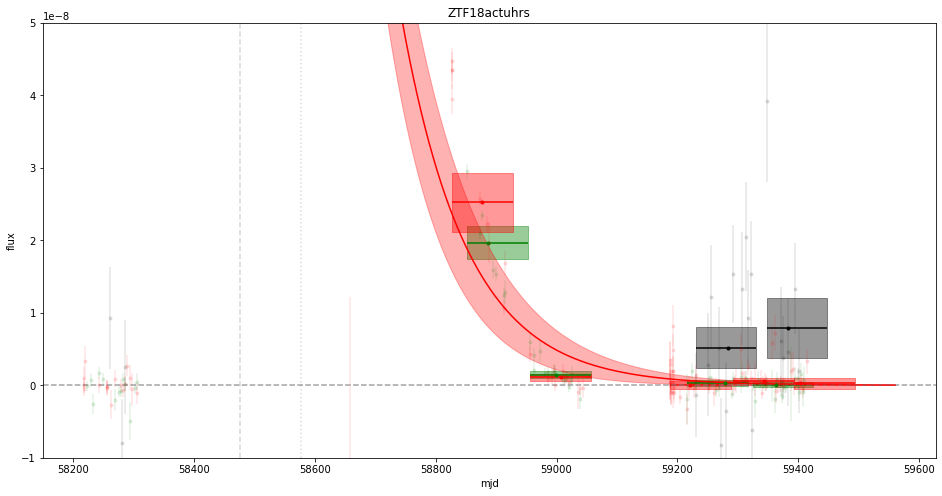

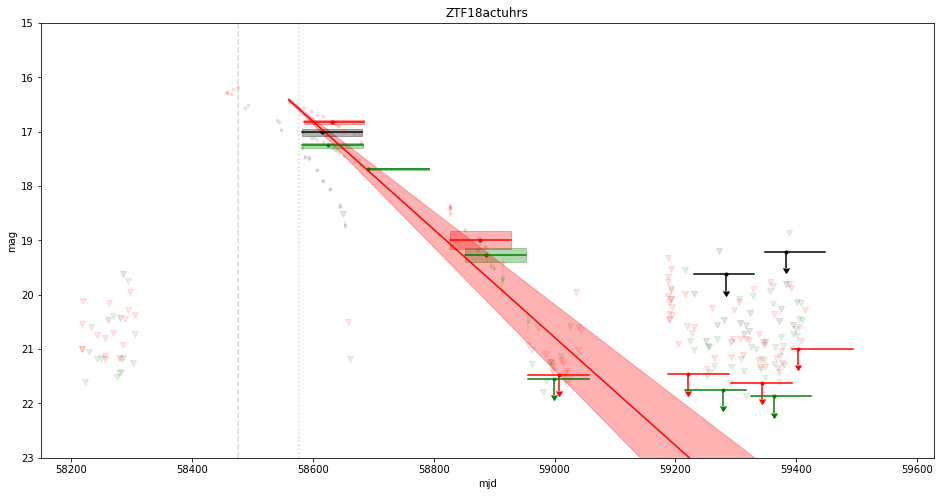

In [4]:
#Show the binning result for the first interesting object in flux & mag space
obj = interesting.name.values[0]
binsize = 100
phase=0.0

show_bins(loc/obj, scale='flux', binsize=binsize, phase=phase, ylim=(-1e-8, 5e-8), show_fit=True)
show_bins(loc/obj, scale='mag', binsize=binsize, phase=phase, ylim=(23, 15), show_fit=True)

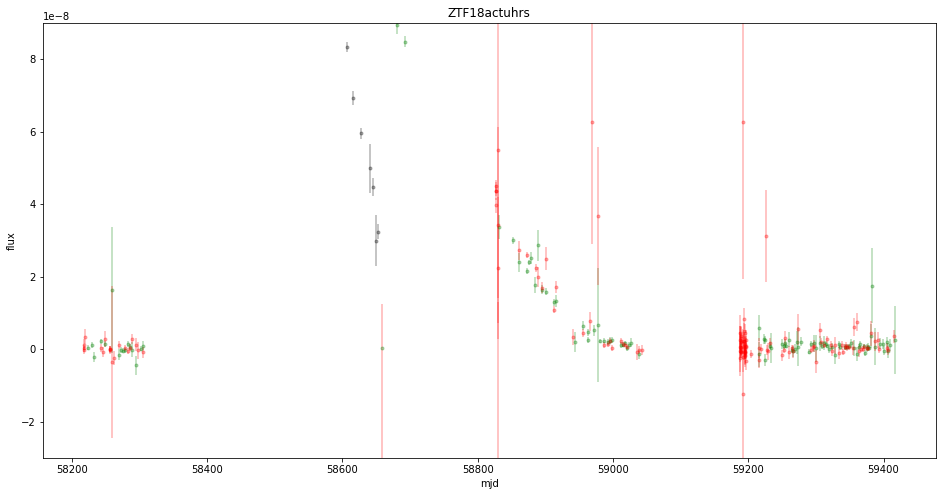

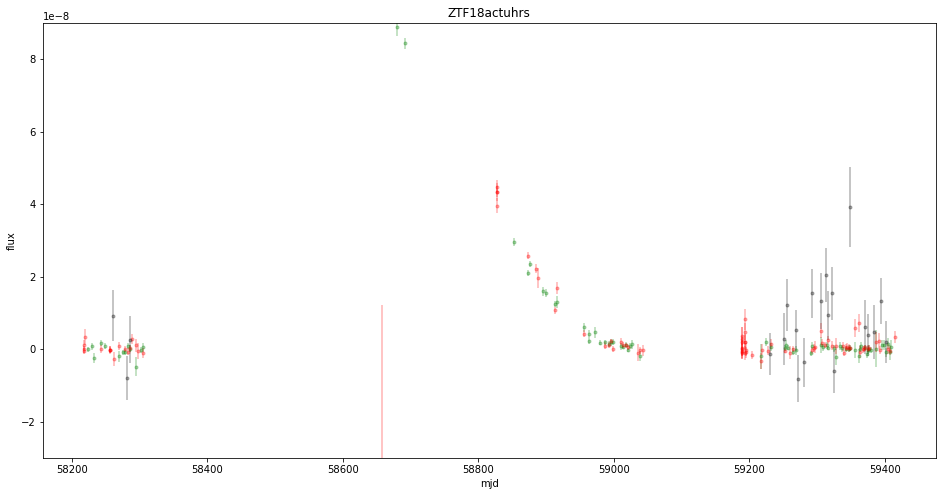

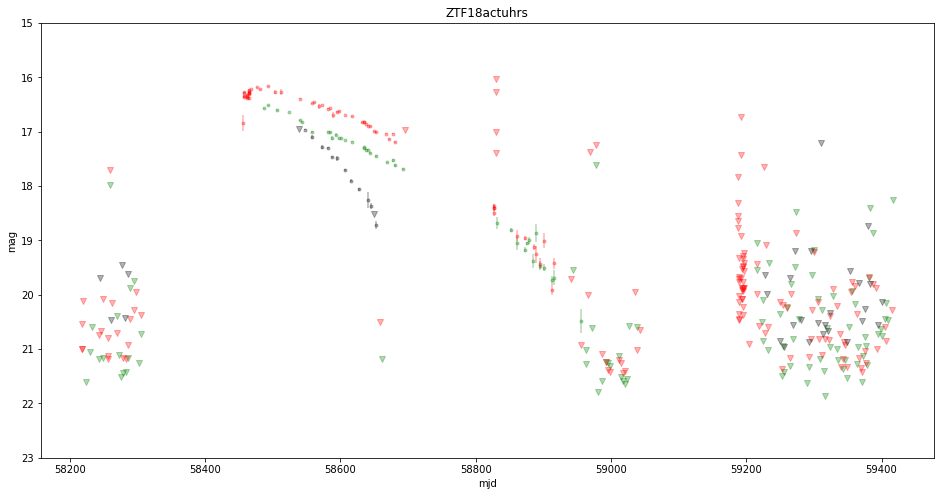

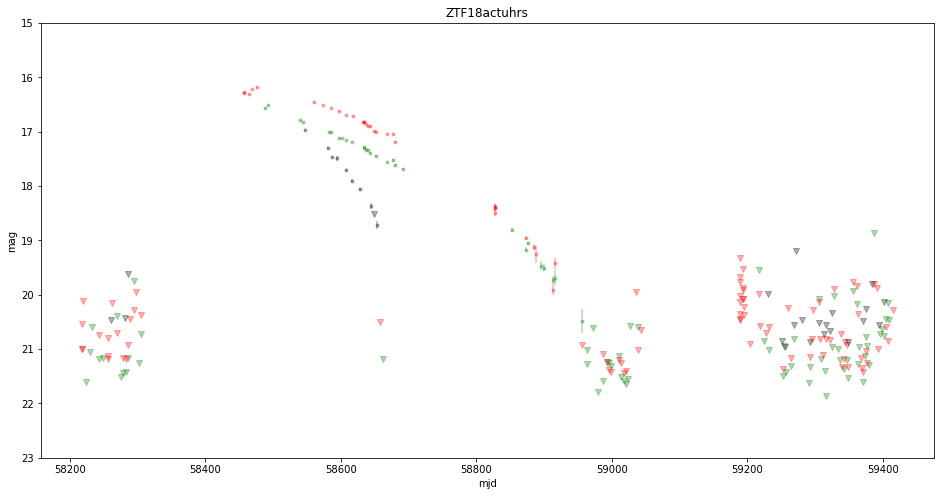

In [5]:
#For the same object, show the original light curve and after baseline corrections and cuts in flux and mag space
show_lc(loc/obj, 'orig', ylim=(-3e-8, 9e-8))
show_lc(loc/obj, 'cor', ylim=(-3e-8, 9e-8))

show_lc(loc/obj, 'orig', scale='mag', ylim=(23, 15))
show_lc(loc/obj, 'cor', scale='mag', ylim=(23, 15))